In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, autoguide, Predictive
from pyro.optim import Adam, ClippedAdam
import torch
import pyro
from torch.distributions import constraints
from pyro.contrib.gp.models.model import GPModel as gpr

/Users/asherkite/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/asherkite/Desktop/School/Courses/MBML/MBML_Project/MBML_github/MBML-traffic-accidents/data/df_hourly_january.csv', parse_dates=['datetime'])
df.set_index(['datetime', 'cell_id'], inplace=True)

In [3]:
df

,,acc_count,X,Y
datetime,cell_id,,,
2023-01-01 00:00:00,"(720517.001, 6172015.001)",0,NaN,NaN
2023-01-01 01:00:00,"(720517.001, 6172015.001)",0,NaN,NaN
2023-01-01 02:00:00,"(720517.001, 6172015.001)",0,NaN,NaN
2023-01-01 03:00:00,"(720517.001, 6172015.001)",0,NaN,NaN
2023-01-01 04:00:00,"(720517.001, 6172015.001)",0,NaN,NaN
...,...,...,...,...
2023-01-31 19:00:00,"(727017.001, 6178015.001)",0,NaN,NaN
2023-01-31 20:00:00,"(727017.001, 6178015.001)",0,NaN,NaN
2023-01-31 21:00:00,"(727017.001, 6178015.001)",0,NaN,NaN


In [4]:
# --- Toy subset: first calendar month ------------------------------------------------
df_day = df.copy()

# Convert UTM (metres) to kilometres for nicer kernel length‑scale priors
coords = df_day[["X", "Y"]].dropna().values / 1_000.0  # shape (n_points, 2)

# Re‑centre so the south‑west corner is (0,0)
coords = coords - coords.min(0, keepdims=True)

In [5]:
cell_size = 0.5  # km – feel free to shrink if memory explodes

nx = int(np.ceil(coords[:, 0].max() / cell_size)) + 1
ny = int(np.ceil(coords[:, 1].max() / cell_size)) + 1
n_cells = nx * ny
print(f"Grid: {nx} × {ny}  ⇒  {n_cells} cells\n")

# Map each accident into its grid cell id
cell_x = (coords[:, 0] / cell_size).astype(int)
cell_y = (coords[:, 1] / cell_size).astype(int)
cell_ids = cell_x + nx * cell_y

counts = np.bincount(cell_ids, minlength=n_cells)  # accidents per cell
counts = torch.tensor(counts, dtype=torch.float32)

# Pre‑compute grid‑cell centroids (in km)
grid_x, grid_y = np.meshgrid(np.arange(nx), np.arange(ny))
centroids = np.stack([grid_x.ravel(), grid_y.ravel()], 1) * cell_size  # (n_cells, 2)
centroids = torch.tensor(centroids, dtype=torch.float32)

Grid: 15 × 17  ⇒  255 cells



In [6]:
def rbf_kernel(X: torch.Tensor, lengthscale: torch.Tensor, variance: torch.Tensor):
    """Squared‑exponential (RBF) kernel matrix, no jitter added."""
    dists = torch.cdist(X, X)
    return variance * torch.exp(-0.5 * (dists / lengthscale) ** 2)

# Pyro model & guide
def model(counts):
    # GP hyper‑parameters (learned via SVI)
    ls = pyro.param("lengthscale", torch.tensor(1.0), constraint=constraints.positive)
    var = pyro.param("variance", torch.tensor(1.0), constraint=constraints.positive)

    K = rbf_kernel(centroids, ls, var) + 1e-4 * torch.eye(n_cells)

    # Latent GP values f ~ MVN(0, K)
    f = pyro.sample("f", dist.MultivariateNormal(torch.zeros(n_cells), covariance_matrix=K))

    rate = torch.exp(f)  # intensity λ = exp(f)

    with pyro.plate("cells", n_cells):
        pyro.sample("obs", dist.Poisson(rate), obs=counts)


def guide(counts):
    f_loc = pyro.param("f_loc", torch.zeros(n_cells))
    f_scale = pyro.param(
        "f_scale", torch.ones(n_cells), constraint=constraints.positive
    )
    pyro.sample("f", dist.Normal(f_loc, f_scale).to_event(1))

# Inference: SVI
pyro.clear_param_store()
optimizer = ClippedAdam({"lr": 0.05})

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 1000
for step in range(num_steps):
    loss = svi.step(counts)
    if step % 100 == 0:
        print(f"[step {step:4d}]  ELBO = {-loss:.2f}")

# Posterior mean intensity map (λ̂)
f_post = pyro.param("f_loc").detach()
lambda_post = torch.exp(f_post).reshape(ny, nx)  # (row, col)

print("\nPosterior mean intensity per grid cell (top‑left 5×5 block):\n")
print(lambda_post[:5, :5])


[step    0]  ELBO = -568110.99
[step  100]  ELBO = -307.38
[step  200]  ELBO = -290.94
[step  300]  ELBO = -287.03
[step  400]  ELBO = -289.66
[step  500]  ELBO = -290.92
[step  600]  ELBO = -284.19
[step  700]  ELBO = -288.66
[step  800]  ELBO = -286.72
[step  900]  ELBO = -307.80

Posterior mean intensity per grid cell (top‑left 5×5 block):

tensor([[0.2992, 0.1764, 0.2064, 0.2406, 0.2146],
        [0.1945, 0.1819, 0.1794, 0.1674, 0.2122],
        [0.2417, 0.2351, 0.2132, 0.2876, 0.1314],
        [0.5811, 0.2664, 1.1481, 0.7139, 0.2701],
        [0.3080, 0.2686, 0.6631, 1.2096, 1.3315]])


### Plotting with grid

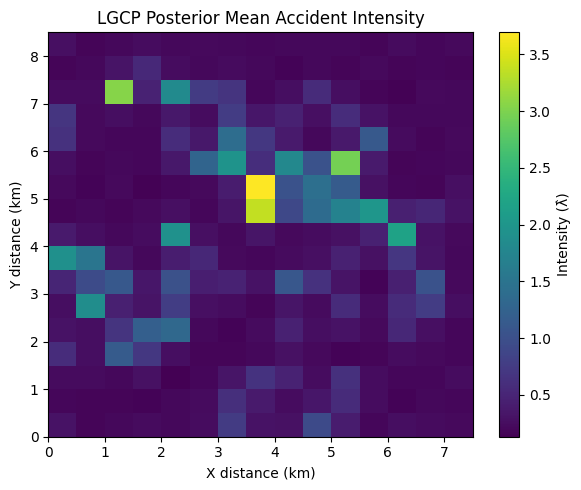

In [7]:
import matplotlib.pyplot as plt

# Get the posterior latent mean and intensity
f_post = pyro.param("f_loc").detach()                   # shape (n_cells,)
lambda_post = torch.exp(f_post).reshape(ny, nx)        # (rows=ny, cols=nx)

# Plot as a heatmap over your grid
fig, ax = plt.subplots(figsize=(6, 5))
extent = (0, nx * cell_size, 0, ny * cell_size)  # x from 0→max, y from 0→max in km
im = ax.imshow(lambda_post.numpy(), origin="lower", extent=extent, aspect="auto")
ax.set_xlabel("X distance (km)")
ax.set_ylabel("Y distance (km)")
ax.set_title("LGCP Posterior Mean Accident Intensity")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Intensity (λ̂)")
plt.tight_layout()
plt.show()


In [9]:
!pip install contextily

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 8.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/asherkite/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


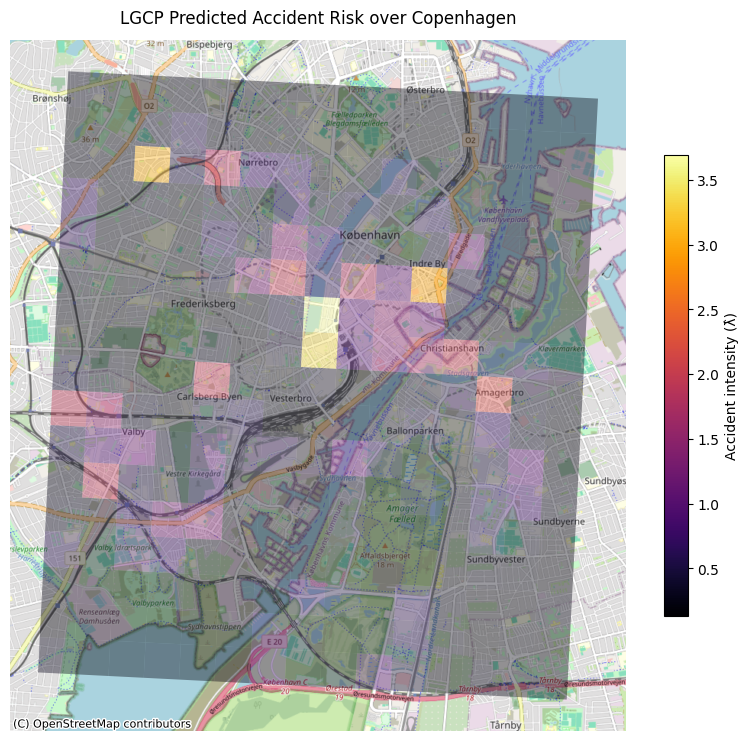

In [10]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon

# Compute the original UTM shift 
coords_orig = df_day[["X","Y"]].dropna().values / 1000.0           # km
offset_km = coords_orig.min(0)                                   # (x_min, y_min) in km

# Convert each relative centroid back to absolute UTM (in metres)
# centroids was shaped (n_cells,2) in km relative to offset_km.
abs_centroids_km = centroids.numpy() + offset_km[None, :]        # km
abs_centroids_m  = abs_centroids_km * 1000                       # metres

# Build square polygons around each centroid
polys = []
intensities = []
for (x_c, y_c), lam in zip(abs_centroids_m, torch.exp(f_post).numpy()):
    half = cell_size * 500   #  cell_size/2 in km → *1000/2 in metres = *500
    # corners in metres
    poly = Polygon([
        (x_c - half, y_c - half),
        (x_c + half, y_c - half),
        (x_c + half, y_c + half),
        (x_c - half, y_c + half),
    ])
    polys.append(poly)
    intensities.append(float(lam))

gdf = gpd.GeoDataFrame(
    {"intensity": intensities},
    geometry=polys,
    crs="EPSG:25832"   # UTM zone 32N
)

# Reproject for web‐tiles
gdf_web = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(8,8))
gdf_web.plot(
    column="intensity",
    ax=ax,
    alpha=0.4,
    edgecolor="none",
    legend=True,
    cmap="inferno",
    legend_kwds={"label":"Accident intensity (λ̂)", "shrink":0.6},
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
ax.set_title("LGCP Predicted Accident Risk over Copenhagen", pad=12)
plt.tight_layout()
plt.show()


### Not refined...

In [16]:
print(abs_centroids_m.shape)
print(f_post.shape)

(255, 2)
torch.Size([255])


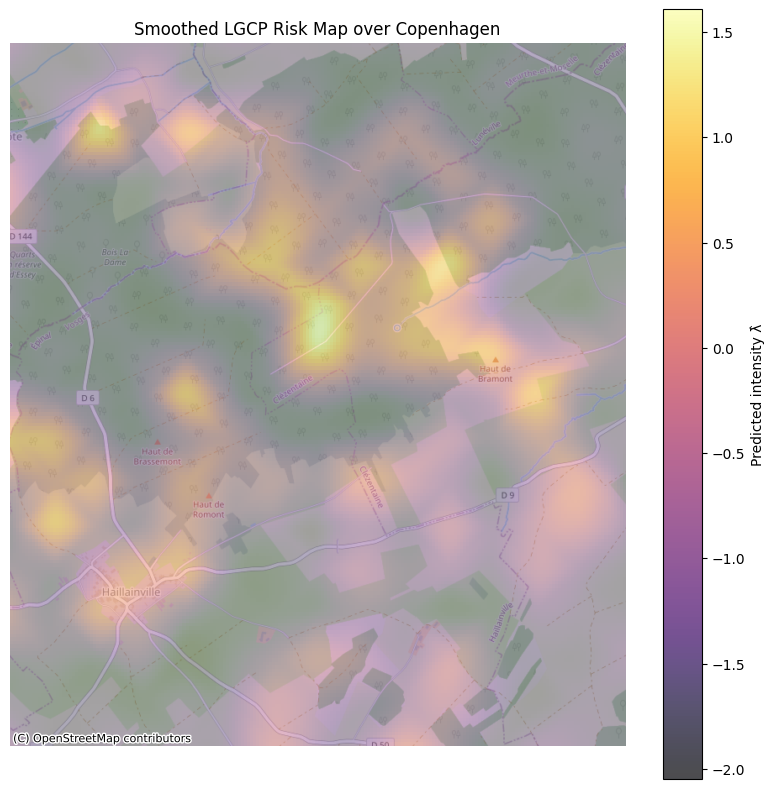

In [20]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Extract your quad locations (in metres) and intensities
"""pts = abs_U_m.numpy()              # shape (M,2), UTM metres
vals = lambda_quad.numpy()         # shape (M,)"""
pts = abs_centroids_m.copy()
vals = f_post.numpy()

# 2. Define a regular grid over the bounding box
x_min, y_min = pts.min(axis=0)
x_max, y_max = pts.max(axis=0)
nx, ny = 200, 200
xi = np.linspace(x_min, x_max, nx)
yi = np.linspace(y_min, y_max, ny)
Xi, Yi = np.meshgrid(xi, yi)

# 3. Interpolate
Zi = griddata(pts, vals, (Xi, Yi), method='cubic', fill_value=np.nan)

# 4. Plot as an image under a basemap
fig, ax = plt.subplots(figsize=(8,8))

# Show the interpolated heatmap (note extent in metres)
im = ax.imshow(Zi,
               origin='lower',
               extent=(x_min, x_max, y_min, y_max),
               cmap='inferno',
               alpha=0.7)
fig.colorbar(im, ax=ax, label='Predicted intensity λ̂')

gdf_web = gdf.to_crs(epsg=3857)

# Overlay OSM tiles
# Convert to EPSG:3857
# We'll need to transform the image, so a simpler workaround is:
# draw the image first, then add basemap:
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
                crs='EPSG:3857',
                alpha=0.5)

ax.set_axis_off()
ax.set_title("Smoothed LGCP Risk Map over Copenhagen")
plt.tight_layout()
plt.show()


In [ ]:
gdf_web.total_bounds

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Get the Web-Mercator bounds of your data
xmin, ymin, xmax, ymax = gdf_web.total_bounds  # in EPSG:3857

# 2. Create the figure and add the basemap
fig, ax = plt.subplots(figsize=(8, 8))
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs="EPSG:3857",
    zoom=12,                # adjust up/down for more detail
)

# 3. Plot your interpolated grid‐cells on top
gdf_web.plot(
    column="intensity",
    ax=ax,
    cmap="inferno",
    alpha=0.6,
    edgecolor="none",
    legend=True,
    legend_kwds={"label":"Predicted λ̂", "shrink":0.6},
    zorder=10              # ensure it draws above the basemap
)

# 4. Zoom to your actual data region
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# 5. Tidy up
ax.set_axis_off()
ax.set_title("Smoothed LGCP Accident Risk over Copenhagen", pad=12)
plt.tight_layout()
plt.show()
